In [18]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
import os
import random
import pandas as pd
from scipy import ndimage
from skimage.util import img_as_ubyte
from scipy.linalg import orthogonal_procrustes

from proglearn.sims.gaussian_sim import _generate_2d_rotation
from proglearn.forest import LifelongClassificationForest
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer
from proglearn.voters import TreeClassificationVoter

from skimage.transform import rotate
from multiprocessing import Pool
from functools import partial

In [2]:
context = sns.plotting_context(context="poster", font_scale=1)
sns.set_context(context)

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

In [5]:
# (X_train, y_train) = data[0]
# (X_test, y_test) = data[1]
data_x = np.concatenate([X_train, X_test])
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

In [71]:
# cd proglearn/docs/tutorials/functions/

/proglearn/docs/tutorials/functions


In [13]:
# from rotation_cifar_functions import image_aug, cross_val_data

In [14]:
# cd ../../../..

/


In [6]:
def cross_val_data(data_x, data_y, total_cls=10, n_train=250):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]
    for i in range(total_cls):
        indx = idx[i]#np.roll(idx[i],(cv-1)*100)
        random.shuffle(indx)
        if i==0:
            train_x1 = x[indx[0:n_train],:]
            train_x2 = x[indx[n_train:n_train*2],:]
            train_y1 = y[indx[0:n_train]]
            train_y2 = y[indx[n_train:n_train*2]]
            test_x = x[indx[500:600],:]
            test_y = y[indx[500:600]]
        else:
            train_x1 = np.concatenate((train_x1, x[indx[0:250],:]), axis=0)
            train_x2 = np.concatenate((train_x2, x[indx[250:500],:]), axis=0)
            train_y1 = np.concatenate((train_y1, y[indx[0:250]]), axis=0)
            train_y2 = np.concatenate((train_y2, y[indx[250:500]]), axis=0)
            test_x = np.concatenate((test_x, x[indx[500:600],:]), axis=0)
            test_y = np.concatenate((test_y, y[indx[500:600]]), axis=0)
    return train_x1, train_y1, train_x2, train_y2, test_x, test_y

In [7]:
def image_aug(pic, angle, centroid_x=23, centroid_y=23, win=16, scale=1.45):
    im_sz = int(np.floor(pic.shape[0]*scale))
    pic_ = np.uint8(np.zeros((im_sz,im_sz,3),dtype=int))

    pic_[:,:,0] = ndimage.zoom(pic[:,:,0],scale)

    pic_[:,:,1] = ndimage.zoom(pic[:,:,1],scale)
    pic_[:,:,2] = ndimage.zoom(pic[:,:,2],scale)

    image_aug = rotate(pic_, angle, resize=False)
    image_aug_ = image_aug[centroid_x-win:centroid_x+win,centroid_y-win:centroid_y+win,:]

    return img_as_ubyte(image_aug_)

In [8]:
def generate_posteriors(X, task_id, forest, transformers):
    vote_per_transformer_id = []
    for transformer_id in transformers:
        vote_per_bag_id = []
        for bag_id in range(
            len(forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id])
        ):
            transformer = forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id][
                bag_id
            ]
            X_transformed = transformer.transform(X)
            voter = forest.task_id_to_decider[task_id].transformer_id_to_voters_[transformer_id][bag_id]
            vote = voter.predict_proba(X_transformed)
            vote_per_bag_id.append(vote)
        vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

    return vote_per_transformer_id

In [9]:
def reshape_images(X):
    X = X.reshape((X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))
    return X

In [10]:
def init_forest(max_depth):
    np.random.seed(1)
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}
    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}
    default_decider_class = SimpleArgmaxAverage
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                             default_transformer_kwargs = default_transformer_kwargs,
                             default_voter_class = default_voter_class,
                             default_voter_kwargs = default_voter_kwargs,
                             default_decider_class = default_decider_class)
    return progressive_learner

In [20]:
def experiment(angle, n_trees=16, max_depth=30):
    # generate data
    train_x1, train_y1, train_x2, train_y2, test_x1, test_y1 =\
        cross_val_data(data_x, data_y, total_cls=10)
    _, _, _, _, test_x2, test_y2 =\
        cross_val_data(data_x, data_y, total_cls=10)

    # rotate task2 data
    tmp_data = train_x2.copy()
    for i in range(len(tmp_data)):
        tmp_ = image_aug(tmp_data[i], angle)
        tmp_data[i] = tmp_
    # rotate test2 data
    tmp_data_test = test_x2.copy()
    for i in range(len(tmp_data_test)):
        tmp_ = image_aug(tmp_data_test[i], angle)
        tmp_data_test[i] = tmp_

    # reshape data
    train_x1 = reshape_images(train_x1)
    tmp_data = reshape_images(tmp_data)
    test_x1 = reshape_images(test_x1)
    tmp_data_test = reshape_images(tmp_data_test)
    
    l2f = init_forest(max_depth) 
    l2f.add_task(train_x1, train_y1, decider_kwargs = {"classes" : np.unique(train_y1)})
    l2f.add_task(tmp_data, train_y2, decider_kwargs = {"classes" : np.unique(train_y2)})
    l2f_task1 = generate_posteriors(test_x1, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(tmp_data_test, 1, l2f, [0,1])
    
    # apply orthogonal procrustes
    R1, _ = orthogonal_procrustes(l2f_task1[0], l2f_task2[1])
    R2, _ = orthogonal_procrustes(l2f_task2[1], l2f_task1[0])
    l2f_task1_deformed = l2f_task1[0] @ R1
    l2f_task2_deformed = l2f_task2[1] @ R2

    errors = np.zeros(6, dtype=float)
    # L2F o procrustes
    l2f_pred_task1_proc = np.mean([l2f_task1[0], l2f_task2_deformed], axis=0)
    errors[0] = (1 - np.mean(np.argmax(l2f_pred_task1_proc, axis=1) == test_y1))
    l2f_pred_task2_proc = np.mean([l2f_task2[1], l2f_task1_deformed], axis=0)
    errors[1] = (1 - np.mean(np.argmax(l2f_pred_task2_proc, axis=1) == test_y2))

    # L2F
    l2f_pred_task1 = np.mean([l2f_task1[0], l2f_task1[1]], axis=0)
    errors[2] = (1 - np.mean(np.argmax(l2f_pred_task1, axis=1) == test_y1))
    l2f_pred_task2 = np.mean([l2f_task2[0], l2f_task2[1]], axis=0)
    errors[3] = (1 - np.mean(np.argmax(l2f_pred_task2, axis=1) == test_y2))
    
    # UF
#     uf_pred_task1 = uf1.predict(test_x1, task_id=0)
#     errors[4] = 1 - np.mena(uf_pred_task1 == test_y1)
#     uf_pred_task2 = uf1.predict(tmp_data_test, task_id=0)
#     errors[5] = 1 - np.mena(uf_pred_task2 == test_y2)
    
    return errors

In [60]:
experiment(0)

array([0.667, 0.576, 0.683, 0.556, 0.   , 0.   ])

In [33]:
def run():
    angles = [0,30,60,90,120,150,180]
    errors = np.empty((len(angles), 6))
    for i,angle in enumerate(angles):
        errors[i,:] = experiment(angle)
        
    return errors

In [21]:
run()

[array([[0.646, 0.573, 0.698, 0.555, 0.   , 0.   ],
        [0.685, 0.575, 0.696, 0.55 , 0.   , 0.   ]])]

In [34]:
rep = 20
errors_all = Parallel(n_jobs=5, verbose=1)(delayed(run)() for _ in range(rep))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  9.1min finished


In [36]:
errors_all_avg = np.mean(errors_all, axis=0)
errors_all_avg

array([[0.67705, 0.58295, 0.70955, 0.5416 , 0.     , 0.     ],
       [0.6703 , 0.5729 , 0.70595, 0.5389 , 0.     , 0.     ],
       [0.67985, 0.5748 , 0.71125, 0.54275, 0.     , 0.     ],
       [0.6701 , 0.58115, 0.7017 , 0.54695, 0.     , 0.     ],
       [0.67885, 0.57225, 0.7107 , 0.53565, 0.     , 0.     ],
       [0.67005, 0.5785 , 0.709  , 0.54265, 0.     , 0.     ],
       [0.6767 , 0.57575, 0.70975, 0.5372 , 0.     , 0.     ]])

In [100]:
array_ = np.vstack((errors_all_avg[:,:2], errors_all_avg[:,2:4]))
df = pd.DataFrame(array_)
df['alg'] = ""
df['alg'].iloc[[0,1,2,3,4,5,6]] = 'L2F o ortho procrustes'
df['alg'].iloc[[7,8,9,10,11,12,13]] = 'L2F'
df.columns = ['error on task1', 'error on task2', 'alg']
angles = np.append(np.linspace(0,180,num=7), np.linspace(0,180,num=7))
df['Angle of Rotation'] = angles.astype(int)
df = pd.melt(df, id_vars=['alg', 'Angle of Rotation'],\
             var_name='type', value_name='Generalization Error')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


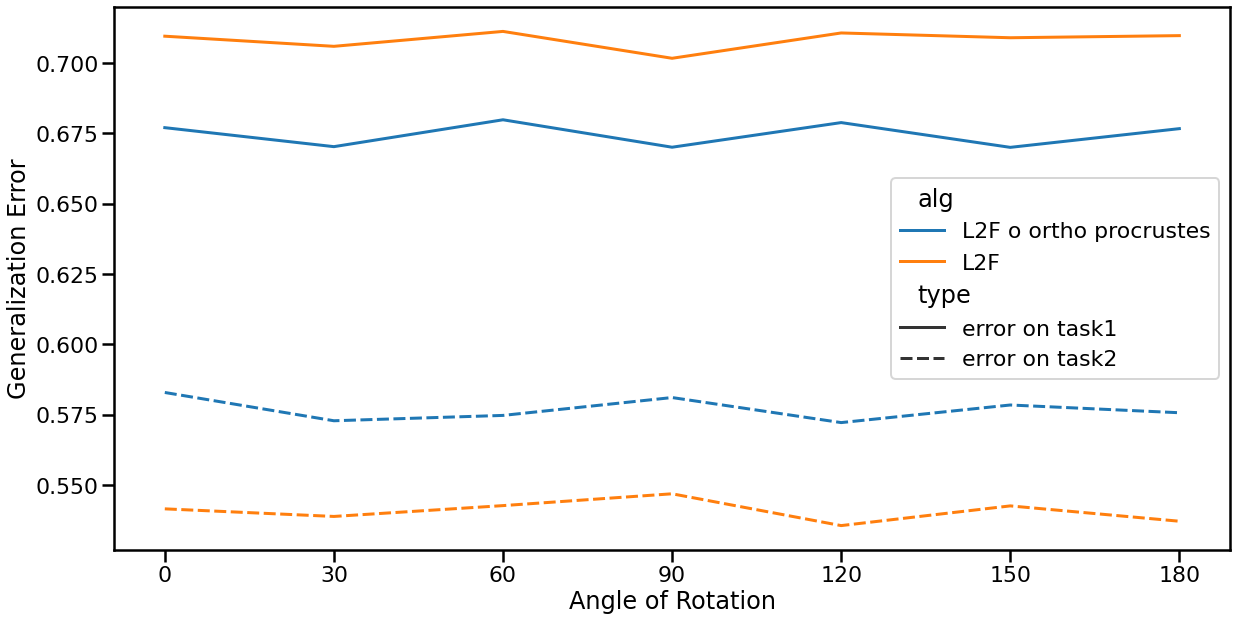

In [104]:
fig,ax = plt.subplots(1, figsize=(20,10))
sns.lineplot(data=df, x=df['Angle of Rotation'], y=df['Generalization Error'], hue='alg', style='type', ax=ax)
ax.set_xticks(np.linspace(0,180,num=7))
